<a href="https://colab.research.google.com/github/BifoldTide/-Core-Autos-Usados/blob/main/(Core)_Predicci%C3%B3n_de_precios_de_veh%C3%ADculos_usados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Carga de librerías y datos

In [1]:
# Importamos las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cargamos los datos
path = "/content/drive/MyDrive/BBDD SONDA/used_vehicles.csv"
df = pd.read_csv(path)

# Comprobamos que funcione
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [3]:
# Vemos el status del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

### Limpieza y llenado de datos

In [4]:
# Eliminemos la columna County y busquemos duplicados
df.drop(columns = "county", inplace = True)
df[df.duplicated()] # No hay duplicados

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date


In [5]:
# Busquemos las columnas con muchos nulos y las sacamos (no sirven)
fil_nas_id = df[df["model"].isna() & df["condition"].isna() & df["type"].isna() & df["manufacturer"].isna() & df["year"].isna() & df["cylinders"].isna()]["id"]
df = df[~df["id"].isin(fil_nas_id)]

In [6]:
# Quitemos las demás columnas que no sirven para nuestra predicción
df.drop(columns = ["url", "region_url", "VIN", "image_url", "description", "paint_color"], inplace = True)
df.drop(columns = ["cylinders", "drive", "size", "type", "condition"], inplace = True )

In [7]:
# Veamos los valores de las columnas
df["region"].unique()
df["year"].value_counts() # Hay datos de años de autos demasiado viejos
df[df["year"] < 1950]["year"].value_counts().sort_index() # Hay varios, así que los conservo
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 426812 entries, 27 to 426879
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426812 non-null  int64  
 1   region        426812 non-null  object 
 2   price         426812 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   fuel          423867 non-null  object 
 7   odometer      422480 non-null  float64
 8   title_status  418638 non-null  object 
 9   transmission  424324 non-null  object 
 10  state         426812 non-null  object 
 11  lat           420331 non-null  float64
 12  long          420331 non-null  float64
 13  posting_date  426812 non-null  object 
dtypes: float64(4), int64(2), object(8)
memory usage: 48.8+ MB


In [8]:
# Llenas los datos faltantes. En este caso, usé las medias y las modas
df["year"] = df["year"].interpolate()
df["year"] = df["year"].astype(np.int64)
df["manufacturer"] = df["manufacturer"].fillna(df[~df["manufacturer"].isna()]["manufacturer"].mode().values.tolist()[0])
df["model"] = df["model"].ffill()
df["fuel"] = df["fuel"].ffill()
df["model"].ffill()
df["odometer"] = df["odometer"].fillna(df[~df["odometer"].isna()]["odometer"].mean())
df["transmission"] = df["transmission"].fillna("automatic")
df["title_status"] = df["title_status"].fillna(df[~df["title_status"].isna()]["title_status"].mode().values.tolist()[0])
df["lat"] = df["lat"].fillna(df[~df["lat"].isna()]["lat"].mean())
df["long"] = df["long"].fillna(df[~df["long"].isna()]["long"].mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 426812 entries, 27 to 426879
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426812 non-null  int64  
 1   region        426812 non-null  object 
 2   price         426812 non-null  int64  
 3   year          426812 non-null  int64  
 4   manufacturer  426812 non-null  object 
 5   model         426812 non-null  object 
 6   fuel          426812 non-null  object 
 7   odometer      426812 non-null  float64
 8   title_status  426812 non-null  object 
 9   transmission  426812 non-null  object 
 10  state         426812 non-null  object 
 11  lat           426812 non-null  float64
 12  long          426812 non-null  float64
 13  posting_date  426812 non-null  object 
dtypes: float64(3), int64(3), object(8)
memory usage: 48.8+ MB


In [9]:
#Remoción de los outliers
# df = df[df["price"] <= 250000] # mayor al promedio
df[df["price"] == 0] # Son muchos

# Notificar que son valores 0, dado que no se sabe el estado actual del vehiculo
df['is_price_zero'] = (df['price'] == 0).astype(int)

# Regularizar valores cero para no perder las filas
df['price'] = df['price'].replace(0, 1)

### Interpretación de datos

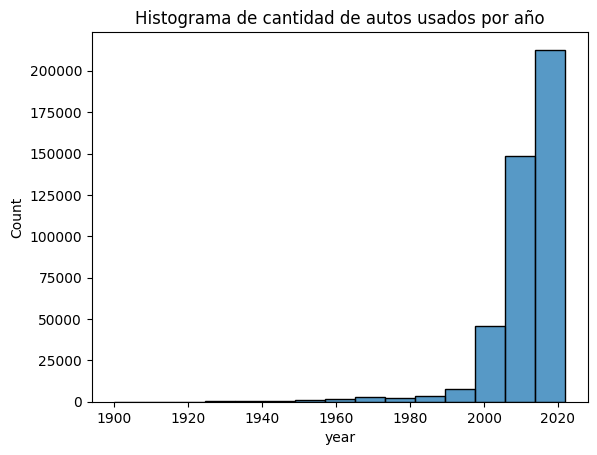

In [10]:
# Histograma de autos por año
df.describe()
sns.histplot(data = df, x = "year", bins = 15)
plt.title("Histograma de cantidad de autos usados por año")
plt.show()

Text(0.5, 1.0, 'Precio de autos usados según kilometraje')

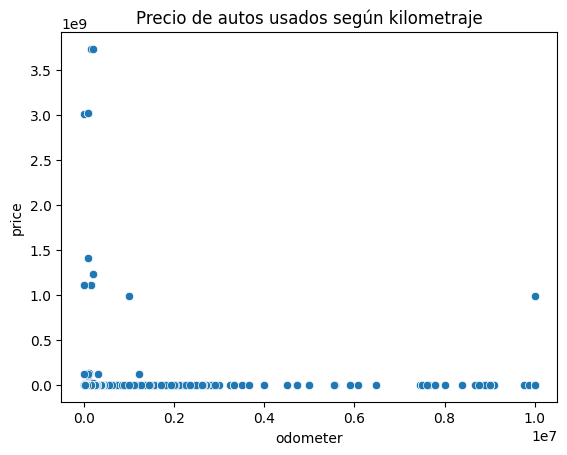

In [11]:
# Dispersión por precio y kilometraje
sns.scatterplot(data = df, x = "odometer", y = "price")
plt.title("Precio de autos usados según kilometraje")

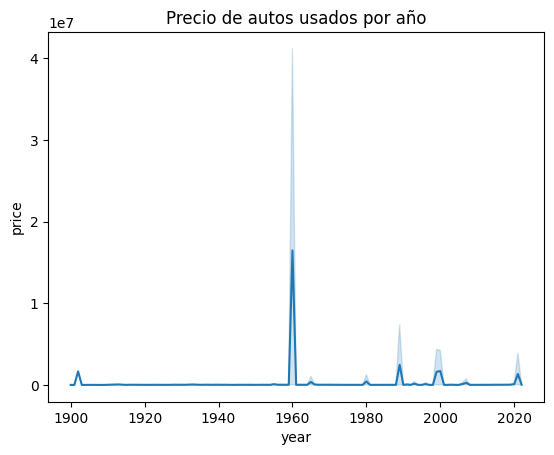

In [12]:
# Precio de autos por año
sns.lineplot(data = df, x = "year", y = "price")
plt.title("Precio de autos usados por año")
plt.show()

### Entrenamiento de modelos

In [13]:
# Entrenamiento de modelos de regresión
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [14]:
# Clasificación de datos
X = df.drop(columns = "price")
y = df["price"]

In [15]:
# Partición de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state =96)

# Definir columnas
col_num = ["id", "year", "odometer", "lat", "long"]
col_nom = ["region", "manufacturer", "model", "fuel", "title_status", "transmission", "state", "posting_date"]

In [16]:
# Transformar datos
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), col_num),
    ("nom", OneHotEncoder(handle_unknown='ignore'), col_nom)
])

In [17]:
# Entrenamiento de modelos

# Línea
pipeline_line = Pipeline(steps=[
    ("pp", preprocessor),
    ("model", LinearRegression())])

# Random Forest regressor
pipeline_forest = Pipeline(steps=[
    ("pp", preprocessor),
    ("model", RandomForestRegressor(n_estimators=100, random_state=96))])



In [ ]:
# Entrenamiento y predicciones
pipeline_line.fit(X_train, y_train)
pipeline_forest.fit(X_train, y_train)


y_pred_line = pipeline_line.predict(X_test)
y_pred_forest = pipeline_forest.predict(X_test)